In [1]:
import os
import pandas as pd
import re
import pickle as pkl
import matplotlib.pyplot as plt
from statistics import mean
import plotly.express as px
import plotly.graph_objects as go
from math import cos, sin, acos

from dtw_util import *

# load the data
regex = re.compile('.*NDI*$')
folder = os.path.join('ndi_servo_video', '2022-05-26')
demos = sorted(os.listdir(folder))
gripper_data = {}
open_close_data = {}
for demo in demos:
    demo_folder = os.path.join(folder, demo)
    file_set = sorted(os.listdir(demo_folder))
    for file in file_set:
        file_path = os.path.join(demo_folder, file)
        if "NDI_postprocessed.txt" in file:
            gripper_data[demo] = pd.read_csv(file_path)
        elif "displacement_postprocessed" in file:
            open_close_data[demo] = pd.read_csv(file_path)

def angle_diff(r0, r1):
    """for measuring """
    nr0 = np.linalg.norm(r0)
    nr1 = np.linalg.norm(r1)
    cs = cos(nr0/2)*cos(nr1/2) 
    sn = sin(nr0/2)*sin(nr1/2)*np.dot(r0,r1)/(nr1*nr0)
    return np.abs(2*acos(cs+sn))

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# preprocessing and convert to speed and rotation
rot_data = {}
task_data = {}
data_lens = []
num_demos = len(gripper_data.keys())

for demo in gripper_data.keys():
    df = gripper_data[demo]
    close_t, open_t = open_close_data[demo].iloc[0].Timestamp, open_close_data[demo].iloc[1].Timestamp
    df = df.loc[df.Time < open_t].loc[close_t < df.Time]
    df.Time = df.Time - df.Time.iloc[0]
    rot_seq = []
    for i in range(1, len(df)):
        r0 = df.iloc[i-1][['Rx', 'Ry', 'Rz']]
        r1 = df.iloc[i][['Rx', 'Ry', 'Rz']]
        rot_seq.append(angle_diff(r0, r1))
    rot_data[demo] = rot_seq
    
    task_data[demo] = df.copy()
    time_diff = df['Time'].diff(1)
    # convert speed to mm/s
    temp = ((np.sqrt(np.square(df.loc[:, ['x','y','z']].diff(1)).sum(axis=1))))/time_diff
    task_data[demo]['Speed'] = np.array(temp)
    task_data[demo].dropna(inplace=True)
    data_lens.append(len(temp))
    
# get demos with median duration
data_lens = sorted(data_lens)
median_demo = data_lens.index(data_lens[round(num_demos/2)])

In [3]:
# settings and select demos
tag_interval = 20
demo1 = demos[median_demo]
demo2 = demos[7]

# run DTW
test_demo1, test_demo2 = task_data[demo1]['Speed'].to_numpy(), task_data[demo2]['Speed'].to_numpy()
demo_warped = dynamic_time_warp(test_demo1, test_demo2)[0]

In [4]:
demo_warped

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       [  0,   3],
       [  0,   4],
       [  0,   5],
       [  0,   6],
       [  0,   7],
       [  0,   8],
       [  0,   9],
       [  0,  10],
       [  0,  11],
       [  0,  12],
       [  0,  13],
       [  0,  14],
       [  0,  15],
       [  0,  16],
       [  0,  17],
       [  0,  18],
       [  0,  19],
       [  0,  20],
       [  0,  21],
       [  0,  22],
       [  0,  23],
       [  0,  24],
       [  0,  25],
       [  0,  26],
       [  1,  27],
       [  1,  28],
       [  2,  29],
       [  3,  29],
       [  4,  29],
       [  5,  30],
       [  5,  31],
       [  5,  32],
       [  5,  33],
       [  5,  34],
       [  5,  35],
       [  6,  36],
       [  7,  37],
       [  7,  38],
       [  8,  39],
       [  8,  40],
       [  8,  41],
       [  8,  42],
       [  8,  43],
       [  8,  44],
       [  8,  45],
       [  8,  46],
       [  8,  47],
       [  9,  48],
       [ 10,  49],
       [ 11,

Text(0, 0.5, 'Index 2')

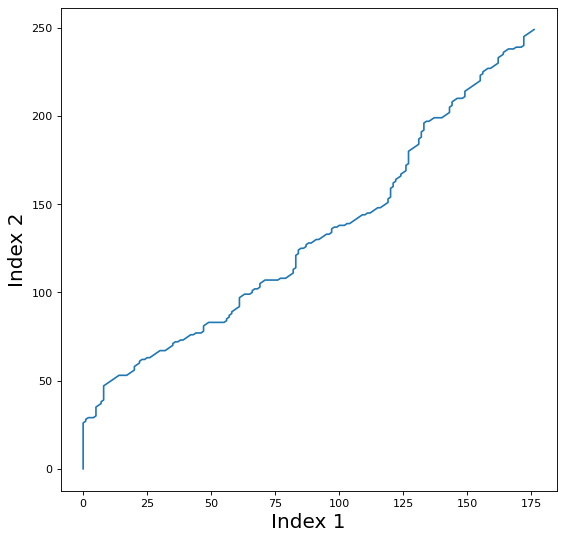

In [5]:
# Show cost minimization path
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(demo_warped[:, 0], demo_warped[:, 1])
plt.xlabel('Index 1', fontsize=18)
plt.ylabel('Index 2', fontsize=18)

Text(0, 0.5, 'Speed')

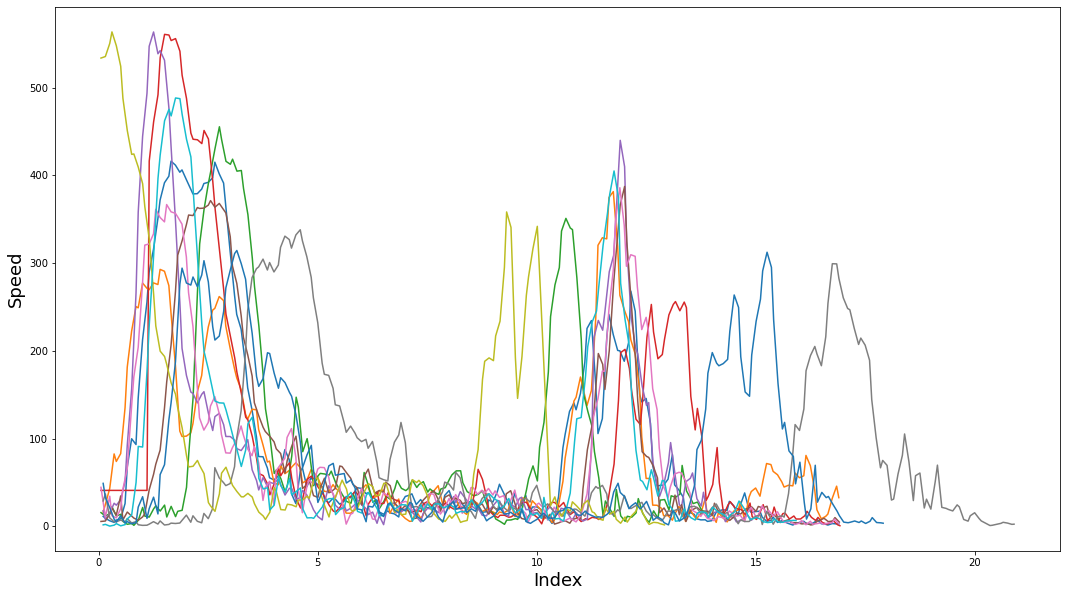

In [6]:
# Show raw demo speed and duration
fig, ax0 = plt.subplots(nrows=1)
fig.set_figheight(10)
fig.set_figwidth(18)
for _, data in task_data.items():
    data_len = len(data)
    ax0.plot(data.Time, data.Speed)
    
ax0.set_xlabel('Index', fontsize=18)
ax0.set_ylabel('Speed', fontsize=18)

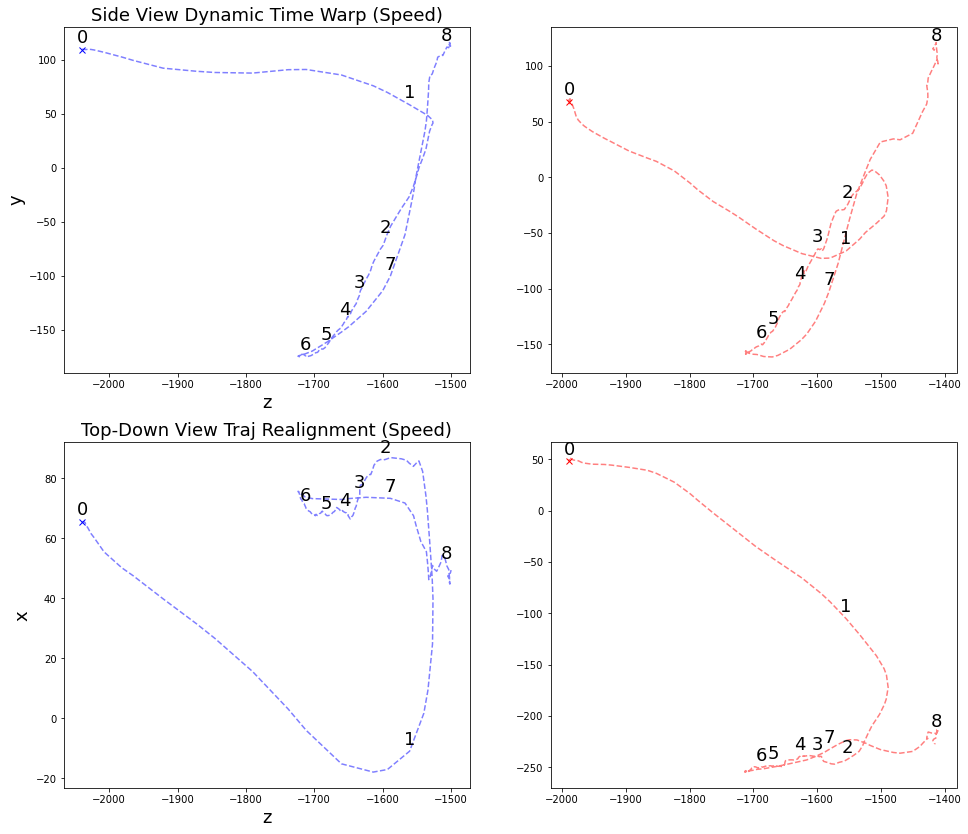

In [7]:
# show some of the corresponding matching indices over trajectory.
demo_df1 = task_data[demo1].copy()
demo_df2 = task_data[demo2].copy()

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(14)
fig.set_figwidth(16)

demo1_match, demo2_match = [], []
demo1_spd_match, demo2_spd_match = [], []
prev_index = -1
for i, match in enumerate(demo_warped):
    if match[0]%tag_interval==0 and match[0]!=prev_index:
        prev_index = match[0]
        demo1_match.append(demo_df1.iloc[match[0]][['x','y','z']])
        demo2_match.append(demo_df2.iloc[match[1]][['x','y','z']])
        demo1_spd_match.append([task_data[demo1].iloc[match[0]].Time, task_data[demo1].iloc[match[0]].Speed])
        demo2_spd_match.append([task_data[demo2].iloc[match[1]].Time, task_data[demo2].iloc[match[1]].Speed])
        
demo1_match = np.array(demo1_match)
demo2_match = np.array(demo2_match)
ax1.plot(demo_df1['z'], demo_df1['x'],'--', color='blue', alpha=.5)
ax1.plot([demo_df1['z'].iloc[0]], [demo_df1['x'].iloc[0]],'x', color='blue')
ax2.plot(demo_df2['z'], demo_df2['x'],'--', color='red', alpha=.5)
ax2.plot([demo_df2['z'].iloc[0]], [demo_df2['x'].iloc[0]],'x', color='red')

ax3.plot(demo_df1['z'], demo_df1['y'],'--', color='blue', alpha=.5)
ax3.plot([demo_df1['z'].iloc[0]], [demo_df1['y'].iloc[0]],'x', color='blue')
ax4.plot(demo_df2['z'], demo_df2['y'],'--', color='red', alpha=.5)
ax4.plot([demo_df2['z'].iloc[0]], [demo_df2['y'].iloc[0]],'x', color='red')

ax1.set_xlabel('z', fontsize=18)
ax1.set_ylabel('y', fontsize=18)
ax1.set_title('Side View Dynamic Time Warp (Speed)', fontsize=18)

ax3.set_xlabel('z', fontsize=18)
ax3.set_ylabel('x', fontsize=18)
ax3.set_title('Top-Down View Traj Realignment (Speed)', fontsize=18)

for i in range(len(demo1_match)):
    ax1.annotate('{}'.format(i),
    xy=demo1_match[i,[2, 0]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
     
    ax3.annotate('{}'.format(i),
    xy=demo1_match[i,[2, 1]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
       
    ax2.annotate('{}'.format(i),
    xy=demo2_match[i,[2, 0]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

    ax4.annotate('{}'.format(i),
    xy=demo2_match[i,[2, 1]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

Demos Length: 14.90607658804781, 20.896681730021598


C:\Users\YCHEN\AppData\Local\Temp/ipykernel_14840/3265232883.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  match_spd_loc1 = np.array((task_data[demo1].Time, demo1_spd_match))
C:\Users\YCHEN\AppData\Local\Temp/ipykernel_14840/3265232883.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  match_spd_loc2 = np.array((task_data[demo2].Time, demo2_spd_match))


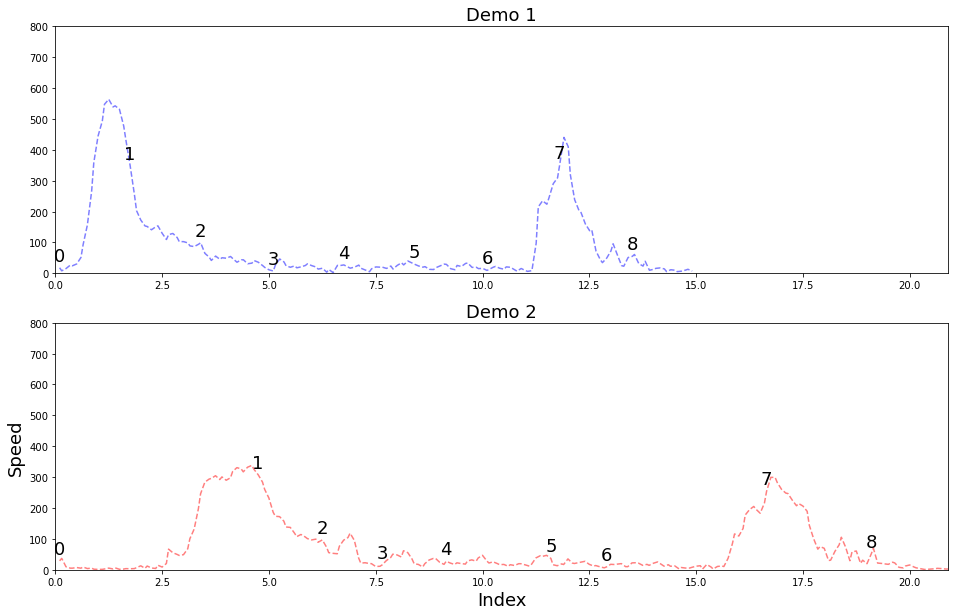

In [8]:
# Show corresponding matching indices over speed and duration
demo1_len = task_data[demo1].Time.iloc[-1]
demo2_len = task_data[demo2].Time.iloc[-1]
match_len = len(demo1_spd_match)

print('Demos Length: {}, {}'.format(demo1_len, demo2_len))
fig, (ax5, ax6) = plt.subplots(nrows=2)
fig.set_figheight(10)
fig.set_figwidth(16)
ax5.plot(task_data[demo1].Time, task_data[demo1].Speed,'--', color='blue', alpha=.5)
ax6.plot(task_data[demo2].Time, task_data[demo2].Speed,'--', color='red', alpha=.5)
ax5.set_title('Demo 1', fontsize=18)
ax6.set_title('Demo 2', fontsize=18)
ax5.set_ylim([0, 800])
ax6.set_ylim([0, 800])
ax5.set_xlim([0, max(demo1_len, demo2_len)])
ax6.set_xlim([0, max(demo1_len, demo2_len)])
ax6.set_xlabel('Index', fontsize=18)
ax6.set_ylabel('Speed', fontsize=18)
match_spd_loc1 = np.array((task_data[demo1].Time, demo1_spd_match))
match_spd_loc2 = np.array((task_data[demo2].Time, demo2_spd_match))
for i in range(match_len):
    ax5.annotate('{}'.format(i),
    xy=demo1_spd_match[i],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
    
    ax6.annotate('{}'.format(i),
    xy=demo2_spd_match[i],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

In [9]:
# apply DTW between the median and all other demos
ref_demo = demos[median_demo]
compare_demo = demo2
min_cost_demos = {}
normalized_demos = {ref_demo:task_data[ref_demo].Speed}
for other_demo in demos:
    ref_demo_data, other_demo_data = task_data[ref_demo][['Time','Speed']].to_numpy(), task_data[other_demo][['Time','Speed']].to_numpy()
    match_indices, min_cost = dynamic_time_warp(ref_demo_data, other_demo_data)
    match_indices = np.array(match_indices)
    min_cost_demos[other_demo] = min_cost
    new_demo = np.zeros(len(ref_demo_data))
    for match in match_indices:
        new_demo[match[0]-1] = other_demo_data[match[1]-1, 1]
    normalized_demos[other_demo] = new_demo

ValueError: setting an array element with a sequence.

In [ ]:
# show speed value of other demo at matching reference indices
ref_demo_len = len(task_data[ref_demo])
orig_demo_len = len(task_data[compare_demo])

fig, (ax7, ax8, ax9) = plt.subplots(nrows=3)
fig.set_figheight(12)
fig.set_figwidth(16)
ax7.plot(range(ref_demo_len), task_data[ref_demo].Speed,'--', color='blue', alpha=.5)
ax8.plot(range(ref_demo_len), normalized_demos[compare_demo],'--', color='red', alpha=.5)
ax9.plot(range(orig_demo_len), task_data[compare_demo].Speed,'--', color='red', alpha=.5)
ax7.set_title('Normalized DTW Demo', fontsize=18)
ax7.set_ylim([0, 800])
ax8.set_ylim([0, 800])
ax9.set_ylim([0, 800])
ax7.set_xlim([0, max(ref_demo_len, orig_demo_len)])
ax8.set_xlim([0, max(ref_demo_len, orig_demo_len)])
ax9.set_xlim([0, max(ref_demo_len, orig_demo_len)])
ax9.set_xlabel('Index', fontsize=18)
ax9.set_ylabel('Speed', fontsize=18)

In [ ]:
# select_index = 50
fig, ax10 = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(16)
for demo_id, norm_demo in normalized_demos.items():
    if ref_demo==demo_id:
        ax10.plot(range(ref_demo_len), norm_demo, alpha=1)
    else:
        ax10.plot(range(ref_demo_len), norm_demo, '--', alpha=.3)
#     ax10.plot(select_index, norm_demo[select_index], 'o')
ax10.set_xlabel("Index", fontsize=18)
ax10.set_ylabel("Speed", fontsize=18)
ax10.set_title("Warped Demonstrations", fontsize=18)

In [ ]:
fig, ax1r = plt.subplots(nrows=1)
fig.set_figheight(10)
fig.set_figwidth(18)
for _, data in rot_data.items():
    data_len = len(data)
    ax1r.plot(range(data_len), data)
    
ax1r.set_xlabel('Index', fontsize=18)
ax1r.set_ylabel('Speed', fontsize=18)

In [ ]:
rot_demo_warped = np.array(dynamic_time_warp(rot_data[demo1], rot_data[demo2])[0])

In [ ]:

fig, ([ax1r, ax2r], [ax3r, ax4r]) = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(14)
fig.set_figwidth(16)

demo1_match, demo2_match = [], []
demo1_rot_match, demo2_rot_match = [], []
prev_index = -1
for i, match in enumerate(rot_demo_warped):
    if match[0]%tag_interval==0 and match[0]!=prev_index:
        prev_index = match[0]
        demo1_match.append(demo_df1.iloc[match[0]][['x','y','z']])
        demo2_match.append(demo_df2.iloc[match[1]][['x','y','z']])
        demo1_rot_match.append([match[0], rot_data[demo1][match[0]]])
        demo2_rot_match.append([match[1], rot_data[demo2][match[1]]])
        
demo1_match = np.array(demo1_match)
demo2_match = np.array(demo2_match)
# plot gaussian product
ax1r.plot(demo_df1['z'], demo_df1['x'],'--', color='blue', alpha=.5)
ax1r.plot([demo_df1['z'].iloc[0]], [demo_df1['x'].iloc[0]],'x', color='blue')
ax2r.plot(demo_df2['z'], demo_df2['x'],'--', color='red', alpha=.5)
ax2r.plot([demo_df2['z'].iloc[0]], [demo_df2['x'].iloc[0]],'x', color='red')

ax3r.plot(demo_df1['z'], demo_df1['y'],'--', color='blue', alpha=.5)
ax3r.plot([demo_df1['z'].iloc[0]], [demo_df1['y'].iloc[0]],'x', color='blue')
ax4r.plot(demo_df2['z'], demo_df2['y'],'--', color='red', alpha=.5)
ax4r.plot([demo_df2['z'].iloc[0]], [demo_df2['y'].iloc[0]],'x', color='red')

ax1r.set_xlabel('z', fontsize=18)
ax1r.set_ylabel('y', fontsize=18)
ax1r.set_title('Side View Dynamic Time Warp (Rotation)', fontsize=18)

ax3r.set_xlabel('z', fontsize=18)
ax3r.set_ylabel('x', fontsize=18)
ax3r.set_title('Top-Down View Dynamic Time Warp (Rotation)', fontsize=18)

for i in range(len(demo1_match)):
    ax1r.annotate('{}'.format(i),
    xy=demo1_match[i,[2, 0]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
     
    ax3r.annotate('{}'.format(i),
    xy=demo1_match[i,[2, 1]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
       
    ax2r.annotate('{}'.format(i),
    xy=demo2_match[i,[2, 0]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

    ax4r.annotate('{}'.format(i),
    xy=demo2_match[i,[2, 1]],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

In [ ]:
demo1_len = len(rot_data[demo1])
demo2_len = len(rot_data[demo2])
match_len = len(demo1_rot_match)

print('Demos Length: {}, {}'.format(demo1_len, demo2_len))
fig, (ax5r, ax6r) = plt.subplots(nrows=2)
fig.set_figheight(7)
fig.set_figwidth(16)
ax5r.plot(range(demo1_len), rot_data[demo1],'--', color='blue', alpha=.5)
ax6r.plot(range(demo2_len), rot_data[demo2],'--', color='red', alpha=.5)
ax5r.set_title('Demo 1', fontsize=18)
ax6r.set_title('Demo 2', fontsize=18)
ax5r.set_ylim([0, .2])
ax6r.set_ylim([0, .2])
ax5r.set_xlim([0, max(demo1_len, demo2_len)])
ax6r.set_xlim([0, max(demo1_len, demo2_len)])
ax6r.set_xlabel('Index', fontsize=18)
ax6r.set_ylabel('Speed', fontsize=18)
match_spd_loc1 = np.array((list(range(match_len)), demo1_rot_match))
match_spd_loc2 = np.array((list(range(match_len)), demo2_rot_match))
for i in range(match_len):
    ax5r.annotate('{}'.format(i),
    xy=demo1_rot_match[i],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)
    
    ax6r.annotate('{}'.format(i),
    xy=demo2_rot_match[i],
    xytext=(0, 3), # 3 points vertical offset
    textcoords="offset points",
    ha='center', va='bottom', fontsize=18)

In [ ]:
normalized_demos_rot = {target_demo:rot_data[target_demo]}
min_cost_demos_rot = {}
for other_demo in demos:
    target_demo_rot, other_demo_rot = rot_data[target_demo].copy(), rot_data[other_demo].copy()
    match_indices, min_cost_rot = dynamic_time_warp(target_demo_rot, other_demo_rot)
    match_indices = np.array(match_indices)
    min_cost_demos_rot[other_demo] = min_cost_rot
    new_demo = np.zeros(len(target_demo_rot))
    for match in match_indices:
        new_demo[match[0]-1] = other_demo_rot[match[1]-1]
    normalized_demos_rot[other_demo] = new_demo
normalized_demos_rot
# select_index = 50
fig, ax10r = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(16)
for _, norm_demo in normalized_demos_rot.items():
    ax10r.plot(range(len(norm_demo)), norm_demo, '--', alpha=.4)
#     ax10.plot(select_index, norm_demo[select_index], 'o')
ax10r.set_xlabel("Index", fontsize=18)
ax10r.set_ylabel("Speed", fontsize=18)
ax10r.set_title("Warped Demonstrations", fontsize=18)

In [ ]:
min_cost_demos_rot